In [139]:
import sys
from pathlib import Path
import os 
ROOT = Path().resolve().parent.parent
sys.path.append(str(ROOT))

In [140]:
import pandas as pd

data = ROOT / 'data' / 'image_quality_metrics.csv'

df = pd.read_csv(data)
df

,path,object,sim,reconstruction,snr,ssim,psnr_no_reference,psnr_reference,peak,rms,sharpness,median,entropy,noise
0,data/processed/img_0000/sim2/tclean_multiscale...,img_0000,sim2,tclean_multiscale_2500,7.978179,0.382072,1.765622,23.657766,255.0,144.425051,13.144426,0.067850,15.996876,0.436437
1,data/processed/img_0000/sim2/tclean_hogbom_400...,img_0000,sim2,tclean_hogbom_40000,9.336039,0.379462,1.431027,24.745150,255.0,178.193650,16.350446,0.163347,15.995575,0.677921
2,data/processed/img_0000/sim2/tclean_mem_1000/t...,img_0000,sim2,tclean_mem_1000,7.377021,0.370901,1.366185,23.255635,255.0,186.651122,11.656647,0.056739,15.995819,0.340941
3,data/processed/img_0000/sim1/tclean_multiscale...,img_0000,sim1,tclean_multiscale_2500,3.915633,0.457655,1.617618,11.070400,255.0,157.639236,34.894677,1.914712,15.993732,3.230500
4,data/processed/img_0000/sim1/tclean_hogbom_400...,img_0000,sim1,tclean_hogbom_40000,4.868769,0.489562,1.483328,13.613603,255.0,171.910701,31.005688,1.801010,15.994758,2.875321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,data/processed/img_0283/sim2/tclean_hogbom_400...,img_0283,sim2,tclean_hogbom_40000,16.121808,0.591912,1.966662,28.479432,255.0,129.661297,14.828530,0.116872,15.997589,0.524034
1708,data/processed/img_0283/sim2/tclean_mem_1000/t...,img_0283,sim2,tclean_mem_1000,16.663782,0.643644,1.915417,28.876434,255.0,133.130306,13.341324,0.043548,15.997589,0.310159
1709,data/processed/img_0283/sim1/tclean_multiscale...,img_0283,sim1,tclean_multiscale_2500,5.308036,0.349318,1.625265,13.827060,255.0,156.897536,18.772305,0.666102,15.996826,1.224755
1710,data/processed/img_0283/sim1/tclean_hogbom_400...,img_0283,sim1,tclean_hogbom_40000,5.658521,0.370528,1.431019,14.862466,255.0,178.194747,19.915585,1.727112,15.997040,2.696233


In [141]:
from sklearn.model_selection import train_test_split

all_objects = df['object'].unique()

trainval_objects, test_objects = train_test_split(all_objects, test_size=0.15, random_state=42)

val_ratio = 0.15 / 0.85
train_objects, val_objects = train_test_split(trainval_objects, test_size=val_ratio, random_state=42)

df_train = df[df['object'].isin(train_objects)].reset_index(drop=True)
df_val = df[df['object'].isin(val_objects)].reset_index(drop=True)
df_test = df[df['object'].isin(test_objects)].reset_index(drop=True)

total = len(df)
print(f"Total: {total}\n")
print(f"Train: {len(df_train)} ({len(df_train)/total:.0%})")
print(f"Validation: {len(df_val)} ({len(df_val)/total:.0%})")
print(f"Test: {len(df_test)} ({len(df_test)/total:.0%})")

Total: 1712

Train: 1188 (69%)
Validation: 266 (16%)
Test: 258 (15%)


In [142]:
import tensorflow as tf
from src.preprocess.image_quality_metrics import ImageQualityMetrics

def load_image(path, size=(256, 256)):
    iqm = ImageQualityMetrics(image_path=str(path))
    image = iqm.data_image
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.grayscale_to_rgb(image)  
    return image

s = 256
size = (s, s)

columns = ['path', 'sharpness', 'entropy', 'median', 'noise']

df_model_train = df_train[columns].copy()
df_model_test = df_test[columns].copy()
df_model_val = df_val[columns].copy()

df_model_train['image'] = df_model_train['path'].apply(lambda x: load_image(ROOT / x, size=size))
df_model_val['image'] = df_model_val['path'].apply(lambda x: load_image(ROOT / x, size=size))
df_model_test['image'] = df_model_test['path'].apply(lambda x: load_image(ROOT / x, size=size))

In [143]:
from sklearn.preprocessing import MinMaxScaler

def scale_features_fit_per_column(df, columns):
    scalers = {}
    df_scaled = df.copy()

    for col in columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled[col] = scaler.fit_transform(df[[col]])
        scalers[col] = scaler

    return df_scaled, scalers

def scale_features_transform_per_column(df, scalers, columns):
    df_scaled = df.copy()

    for col in columns:
        scaler = scalers[col]
        df_scaled[col] = scaler.transform(df[[col]])

    return df_scaled

columns_to_scale = ['sharpness', 'entropy', 'median', 'noise']

df_model_train_scaled, scalers_train = scale_features_fit_per_column(df_model_train, columns_to_scale)

df_model_val_scaled = scale_features_transform_per_column(df_model_val, scalers_train, columns_to_scale)
df_model_test_scaled = scale_features_transform_per_column(df_model_test, scalers_train, columns_to_scale)

In [144]:
alpha, beta, gamma, delta = 0.8, 0.4, 0.3, 0.5

def compute_weighted_score(df):
    return (
        alpha * df['sharpness'] +
        beta  * df['entropy'] +
        gamma * df['median'] +
        delta * df['noise']
    )

df_model_train_scaled['score'] = compute_weighted_score(df_model_train_scaled)
df_model_val_scaled['score']   = compute_weighted_score(df_model_val_scaled)
df_model_test_scaled['score']  = compute_weighted_score(df_model_test_scaled)

In [145]:
scaler_score = MinMaxScaler(feature_range=(0, 1))

df_model_train_scaled['score'] = scaler_score.fit_transform(df_model_train_scaled[['score']])
df_model_val_scaled['score'] = scaler_score.transform(df_model_val_scaled[['score']])
df_model_test_scaled['score'] = scaler_score.transform(df_model_test_scaled[['score']])

In [146]:
import tensorflow as tf
import numpy as np
from src.preprocess.image_quality_metrics import ImageQualityMetrics

def prepare_dataset_from_df(df, batch_size=32, shuffle=True):
    X = []
    y = []

    for _, row in df.iterrows():
        img = row['image']
        score = row['score']

        X.append(img)
        y.append(score)

    X = tf.stack(X)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices(((X), y))

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset_from_df(df_model_train_scaled, batch_size=32)
val_ds = prepare_dataset_from_df(df_model_val_scaled, batch_size=32, shuffle=False)
test_ds = prepare_dataset_from_df(df_model_test_scaled, batch_size=32, shuffle=False)

In [147]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [148]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_regressor_pretrained(input_shape=(128, 128, 3)):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    return model

model = build_regressor_pretrained(input_shape=size + (3,))

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop]
)
model.save('image_quality_regressor.h5')

/var/folders/jd/f_tz2t411v14427qk6ggvkfw0000gn/T/ipykernel_71051/1602972173.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - loss: 0.0307 - mae: 0.1471 - val_loss: 0.0205 - val_mae: 0.1110
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - loss: 0.0196 - mae: 0.1141 - val_loss: 0.0142 - val_mae: 0.0917
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - loss: 0.0143 - mae: 0.0960 - val_loss: 0.0118 - val_mae: 0.0827
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 0.0123 - mae: 0.0856 - val_loss: 0.0107 - val_mae: 0.0780
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - loss: 0.0111 - mae: 0.0812 - val_loss: 0.0100 - val_mae: 0.0746
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.0111 - mae: 0.0801 - val_loss: 0.0095 - val_mae: 0.0721
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.0093 - mae: 0.0730 - val_loss: 0.0090 - val_mae: 0.0699
Epoch 8/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.0093 - mae: 0.0737 - val_loss: 0.0086 - val_mae: 0.0682
Epoch 9/1000
38/38 ━━━━━━━━━━━━━━━━━━

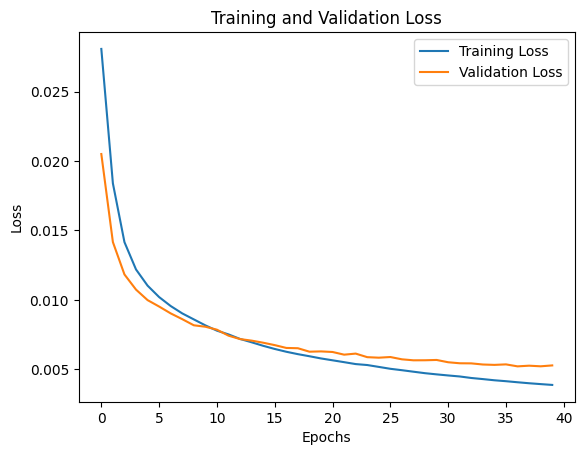

In [149]:
import matplotlib.pyplot as plt
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [150]:
loss, mae = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, MAE: {mae:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0039 - mae: 0.0451
Test Loss: 0.0052, MAE: 0.0518


In [151]:
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().flatten())
    y_pred.extend(preds.flatten())

2025-07-08 21:46:27.191301: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [152]:
print(len(y_true), len(y_pred))

258 258


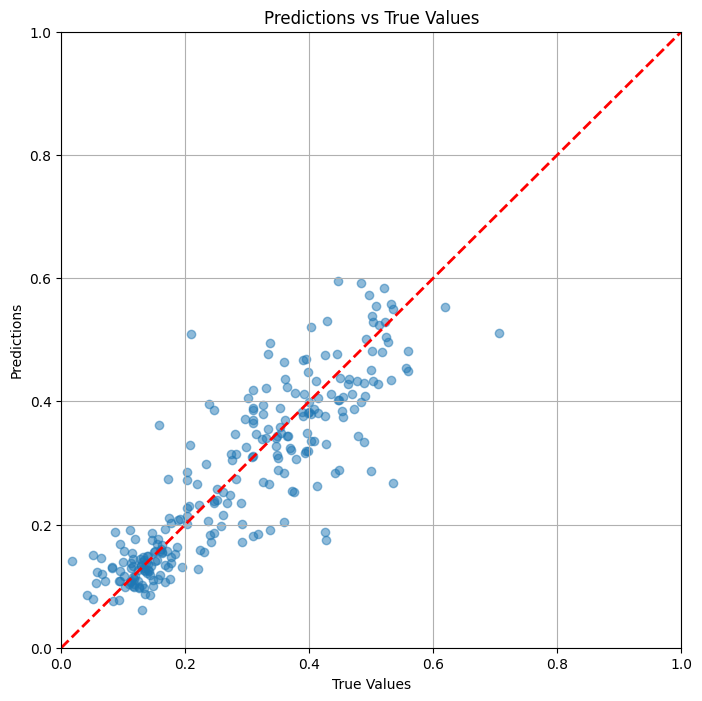

In [153]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

In [154]:
df_test

,path,object,sim,reconstruction,snr,ssim,psnr_no_reference,psnr_reference,peak,rms,sharpness,median,entropy,noise
0,data/processed/img_0005/sim2/tclean_multiscale...,img_0005,sim2,tclean_multiscale_2500,6.612894,0.399284,1.659880,23.262932,255.0,153.625577,13.036808,0.067271,15.996338,0.611893
1,data/processed/img_0005/sim2/tclean_hogbom_400...,img_0005,sim2,tclean_hogbom_40000,11.436319,0.441092,1.802828,25.507278,255.0,141.444448,16.992571,0.150928,15.992939,0.774838
2,data/processed/img_0005/sim2/tclean_mem_1000/t...,img_0005,sim2,tclean_mem_1000,6.125692,0.398310,1.456854,23.053110,255.0,175.034742,11.997178,0.057480,15.995880,0.521135
3,data/processed/img_0005/sim1/tclean_multiscale...,img_0005,sim1,tclean_multiscale_2500,4.164538,0.444474,1.934990,12.733853,255.0,131.783613,28.744936,1.643773,15.995178,2.703825
4,data/processed/img_0005/sim1/tclean_hogbom_400...,img_0005,sim1,tclean_hogbom_40000,4.523090,0.441835,1.621969,14.053651,255.0,157.216282,25.456537,1.476447,15.994099,2.313489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,data/processed/img_0275/sim2/tclean_hogbom_400...,img_0275,sim2,tclean_hogbom_40000,10.201758,0.357802,2.053461,17.629191,255.0,124.180590,24.941535,0.267526,15.995758,1.038564
254,data/processed/img_0275/sim2/tclean_mem_1000/t...,img_0275,sim2,tclean_mem_1000,9.608196,0.381471,1.927087,19.092285,255.0,132.324048,23.165922,0.106199,15.997375,0.629499
255,data/processed/img_0275/sim1/tclean_multiscale...,img_0275,sim1,tclean_multiscale_2500,5.549832,0.413152,1.541937,9.779212,255.0,165.376370,31.274273,1.367724,15.993286,2.537068
256,data/processed/img_0275/sim1/tclean_hogbom_400...,img_0275,sim1,tclean_hogbom_40000,5.042769,0.381732,1.590603,9.433656,255.0,160.316586,29.727959,1.782516,15.993366,2.812812


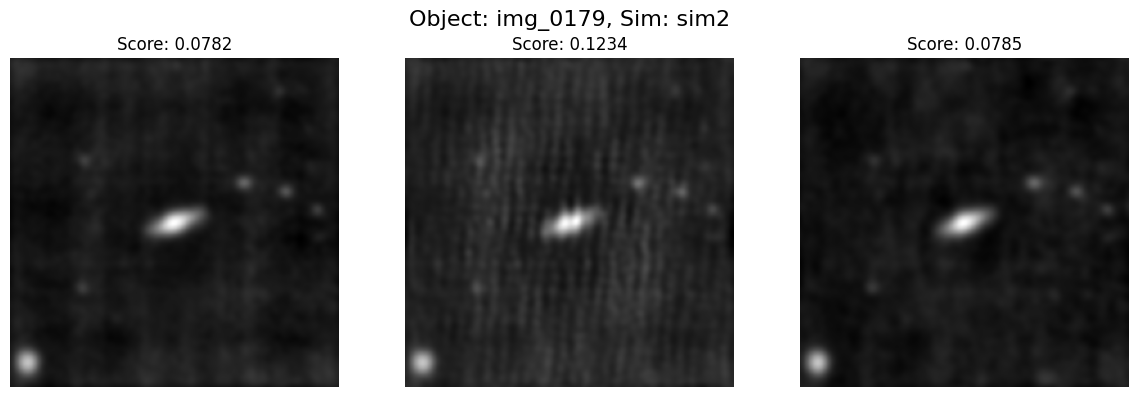

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

unique_combinations = df_test[['object', 'sim']].drop_duplicates().values.tolist()
obj_ref, sim_ref = random.choice(unique_combinations)
matching_paths = df_test[
    (df_test['object'] == obj_ref) &
    (df_test['sim'] == sim_ref)
]['path'].tolist()

images = []
scores = []

for path in matching_paths:
    img = load_image(ROOT / path, size=size)
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    images.append(img.numpy())
    scores.append(pred[0][0])

n = len(images)
cols = min(4, n)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for idx, ax in enumerate(axes.flat):
    if idx < n:
        ax.imshow(images[idx], cmap='inferno')
        ax.set_title(f"Score: {scores[idx]:.4f}")
    ax.axis('off')

plt.suptitle(f"Object: {obj_ref}, Sim: {sim_ref}", fontsize=16)
plt.tight_layout()
plt.show()